In [ ]:
!apt-get install libsuitesparse-dev && pip install git+https://github.com/tansey-lab/bayestme@663b790
!pip install numpy==1.23.5

# Deconvolution

This notebook will cover an example of the deconvolution step of the BayesTME pipeline, using our melanoma dataset as an example.

BayesTME includes a method `bayestme.synthetic_data.generate_demo_dataset` that generates a very small and simple toy dataset we can use for testing and demonstration purposes (A real visium 10x dataset would require too much computation to easily run on google colab for free).

This toy dataset has 6 genes, "north_strong"/"north_weak" which are both expressed more towards the top of the slide, "south_strong"/"south_weak"
which are expressed more towards the bottom of the slide, and "noise_strong"/"noise_weak" which are just random noise. The "strong" genes have 10x higher average absolute counts than the "weak" genes.

In [1]:
from bayestme import data, synthetic_data

stdata = synthetic_data.generate_demo_dataset()

print(stdata.gene_names)

Index(['north_weak', 'north_strong', 'south_weak', 'south_strong',
       'noise_weak', 'noise_strong'],
      dtype='object')


We will assume that M-fold cross-validation has already been run to determine the number of cell types, and given us the value of 2 cell types and spatial smoothing parameter of 1000.0.

We will use these parameters to demonstrate the next step, which is deconvolution.

We support two methods for deconvolution, SVI and MCMC. SVI is our latest version of the model and has much better performance. We recommend users select SVI to start with, but we do support our original MCMC model as well. Both will produce the same end result.

In [2]:
from bayestme import deconvolution
from bayestme.common import InferenceType
best_spatial_smoothing_parameter = 1000.0
best_n_components = 2

deconvolution_result = deconvolution.sample_from_posterior(
    data=stdata,
    n_components=best_n_components,
    spatial_smoothing_parameter=best_spatial_smoothing_parameter,
    n_samples=100,
    n_svi_steps=10_000,
    expression_truth=None,
    use_spatial_guide=True,
    inference_type=InferenceType.SVI)



100%|██████████| 100/100 [00:00<00:00, 411.31it/s]


It's important to inspect the loss plot to make sure that `n_svi_steps` is sufficient and that SVI is has converged.

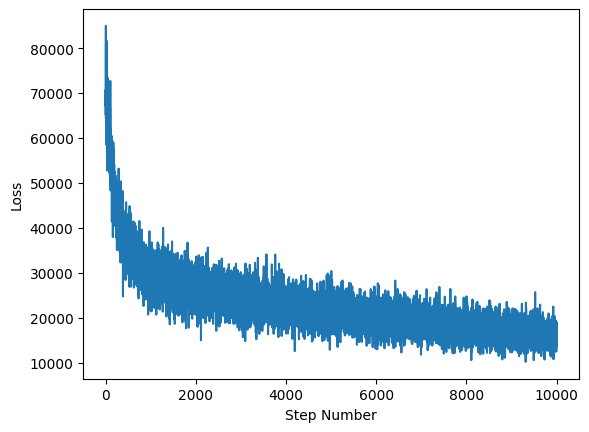

In [7]:
import bayestme.plot.deconvolution

bayestme.plot.deconvolution.plot_loss(deconvolution_result, "./loss.jpg")

In [ ]:
# add the summarized deconvolution results to our anndata archive
# this allows us to save a slim dataset that has all the results in it,
# which is suitable to be shared and explored further

data.add_deconvolution_results_to_dataset(
    stdata, deconvolution_result
)

Next we need to select our marker genes, the genes which identify or characterize our different celltypes. We will also add this information into the anndata archive.

In [ ]:
import bayestme.marker_genes
marker_genes = bayestme.marker_genes.select_marker_genes(
        deconvolution_result=deconvolution_result,
        n_marker=2,
        alpha=1.0,
        method=bayestme.marker_genes.MarkerGeneMethod.TIGHT,
)

bayestme.marker_genes.add_marker_gene_results_to_dataset(
      stdata=stdata, marker_genes=marker_genes
)

Now that we have finished deconvolution and marker gene selection and added the results to the dataset, we can create our suite of deconvolution plots:

In [ ]:
import bayestme.plot.deconvolution
from pathlib import Path
from IPython.display import Image

Path("./deconvolution_plots").mkdir(exist_ok=True)

bayestme.plot.deconvolution.plot_deconvolution(
        stdata=stdata,
        output_dir='./deconvolution_plots',
        output_format='jpg')

This plot shows for each cell type the probability that a spot contains cells of that type. As we can see it follows the pattern we expect with one cell type occupying the northern part of the tissue, and the other occupying the southern part.

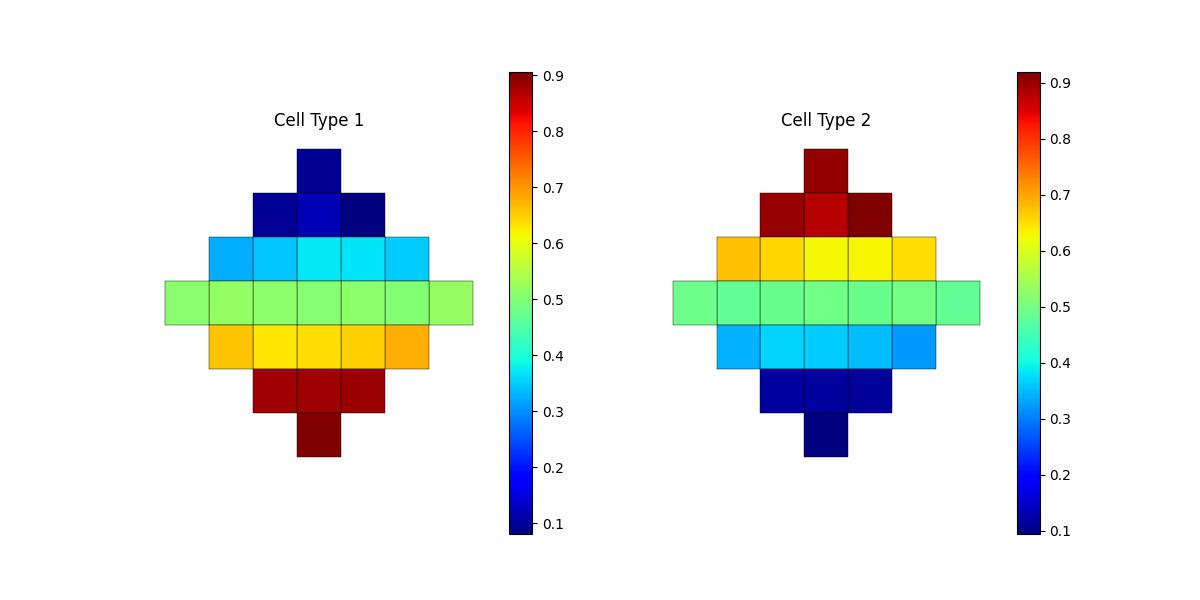

In [ ]:
Image('./deconvolution_plots/cell_type_probabilities.jpg')

The cell number plots show the expected number of cells of each type in each spot.

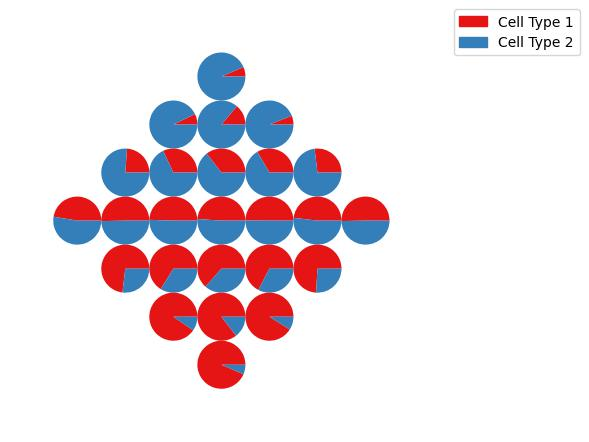

In [ ]:
Image('./deconvolution_plots/cell_num_scatterpie.jpg')

This plot shows the set of genes that are overexpessed in each celltype, or the "marker genes" for that cell type. As expected the two marker genes for the cell type found in the northern part of the slide are "north_strong" and "north_week". "noise_strong" and "noise_weak" don't show up as markers for either cell type, which we also expect.

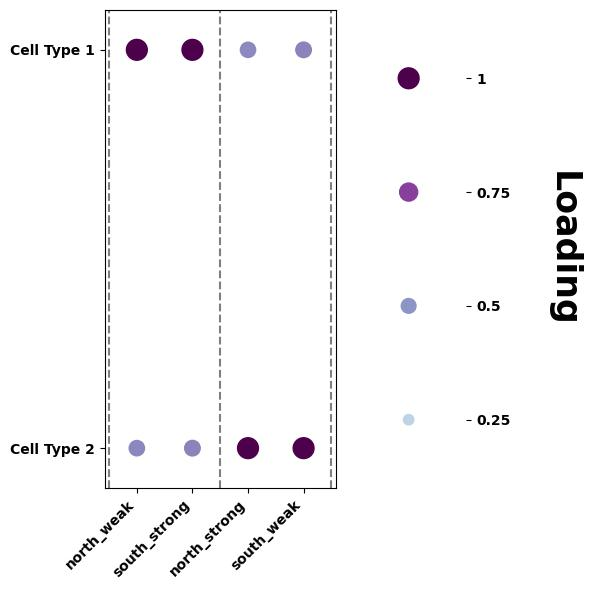

In [ ]:
Image('./deconvolution_plots/marker_genes.jpg')